# Goal Module

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()
from IPython.display import HTML

In [2]:
import numpy as np
import torch

from mantrap.agents import DoubleIntegratorDTAgent
from mantrap.environment import PotentialFieldEnvironment
from mantrap.solver import SGradSolver

pos_init = torch.tensor([-5, 0])
vel_init = torch.ones(2)
goal = torch.tensor([5, 0])

env = PotentialFieldEnvironment(DoubleIntegratorDTAgent, ego_kwargs={"position": pos_init, "velocity": vel_init})

In [3]:
from mantrap.constants import LK_OBJECTIVE
from mantrap.modules import GoalNormModule

solver = SGradSolver(env, goal=goal, t_planning=5, modules=[GoalNormModule])
solver.solve(time_steps=1, multiprocessing=False)

goal_norm_opt =  solver.log_query("goal_norm", key_type=LK_OBJECTIVE, core=solver.core_opt)
goal_norm_opt = list(goal_norm_opt.values())[0][0]  # get best value (only one entry in goal_norm_opt)

goal_norm = solver.log_query("goal_norm", key_type=LK_OBJECTIVE, iteration=0)
goal_norm = {key: np.array(values) / goal_norm_opt for key, values in goal_norm.items()}

In [4]:
from mantrap.modules.baselines import GoalSumModule

solver = SGradSolver(env, goal=goal, t_planning=5, modules=[GoalSumModule])
solver.solve(time_steps=1, multiprocessing=False)

goal_sum_opt =  solver.log_query("goal_sum", key_type=LK_OBJECTIVE, core=solver.core_opt)
goal_sum_opt = list(goal_sum_opt.values())[0][0]  # get best value (only one entry in goal_norm_opt)

goal_sum = solver.log_query("goal_sum", key_type=LK_OBJECTIVE, iteration=0)
goal_sum = {key: np.array(values) / goal_sum_opt for key, values in goal_sum.items()}

<Figure size 432x288 with 0 Axes>

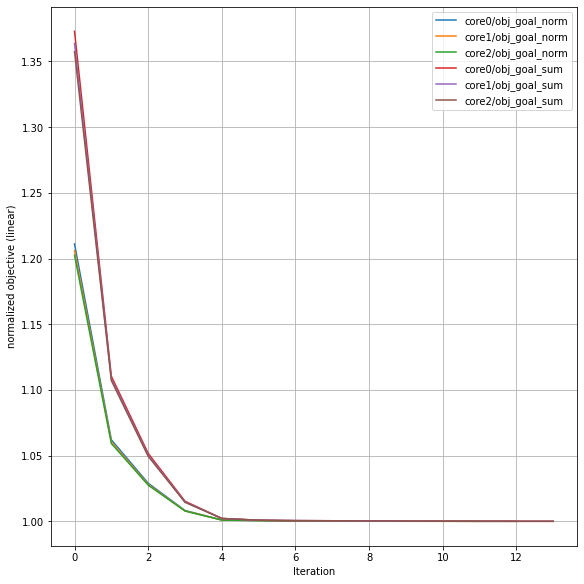

In [5]:
from mantrap.visualization import visualize_curves

comparison_dict = {**goal_norm, **goal_sum}
visualize_curves(comparison_dict, y_label="normalized objective", scale="linear")
plt.show()